In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [5]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [45]:
# Get test split
# bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS']
bands = ['VIIRS']
test_batcher = batcher.Batcher(bands, country_year='malawi-2016', bucket=False, shuffle=False, split='custom', repeat=1, batch_size=3511).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 1)


In [54]:
# Load model
experiments = ['imagery_sample_cnn_regression_NL']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [55]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
    loss=LOSS,
    optimizer=OPT,
    metrics=METRICS,
)

y_preds = trained_model.predict(x_true)
print(y_preds)

 2/21 [=>............................] - ETA: 0s

2023-02-21 21:49:23.256599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 113ms/step
[[-8.969507  ]
 [-7.3143106 ]
 [ 3.2381136 ]
 [-8.751857  ]
 [-7.64807   ]
 [-8.595204  ]
 [-7.291773  ]
 [-6.2427754 ]
 [-9.028399  ]
 [-8.019638  ]
 [-8.250685  ]
 [-3.4720252 ]
 [-8.510167  ]
 [-7.739274  ]
 [-0.21608798]
 [-8.57245   ]
 [-3.7473462 ]
 [-4.429675  ]
 [ 2.2548788 ]
 [-8.341512  ]
 [-9.028399  ]
 [-8.126673  ]
 [-0.03157031]
 [-4.7015843 ]
 [-8.083486  ]
 [-7.97438   ]
 [-5.8962107 ]
 [-8.596778  ]
 [-8.621604  ]
 [-7.561962  ]
 [ 0.06234609]
 [-8.746585  ]
 [ 0.18492354]
 [-4.7015843 ]
 [-8.604655  ]
 [-8.498269  ]
 [-8.392608  ]
 [-7.5771894 ]
 [-2.0041695 ]
 [-8.352356  ]
 [-7.7749157 ]
 [-8.496776  ]
 [-8.440861  ]
 [ 0.37466502]
 [-6.536901  ]
 [-8.61489   ]
 [ 0.51547366]
 [-7.9899983 ]
 [ 0.4546439 ]
 [-8.25194   ]
 [ 9.3930025 ]
 [-8.643788  ]
 [-5.330892  ]
 [-5.4614363 ]
 [-8.973418  ]
 [-8.622972  ]
 [-8.20991   ]
 [-1.8991085 ]
 [-8.621604  ]
 [-1.0937514 ]
 [-7.4608817 ]
 [-8.298094  ]
 [-7.561962  ]


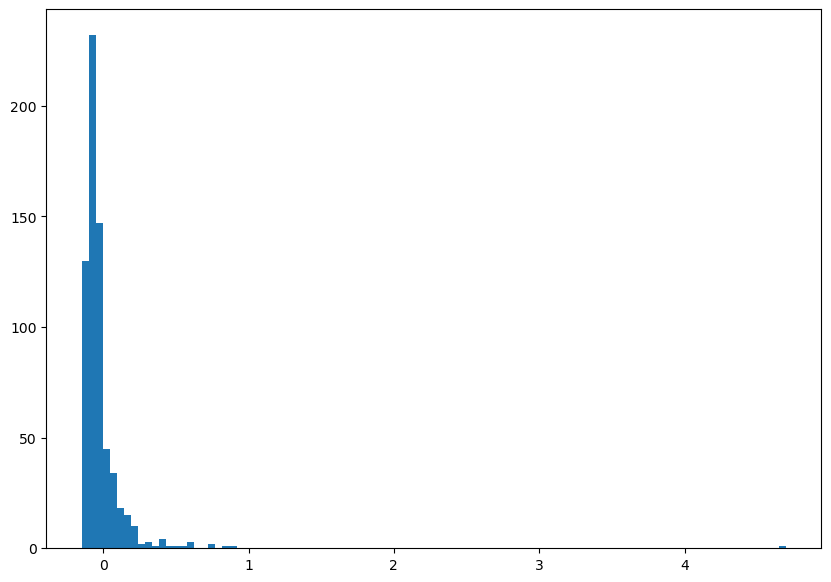

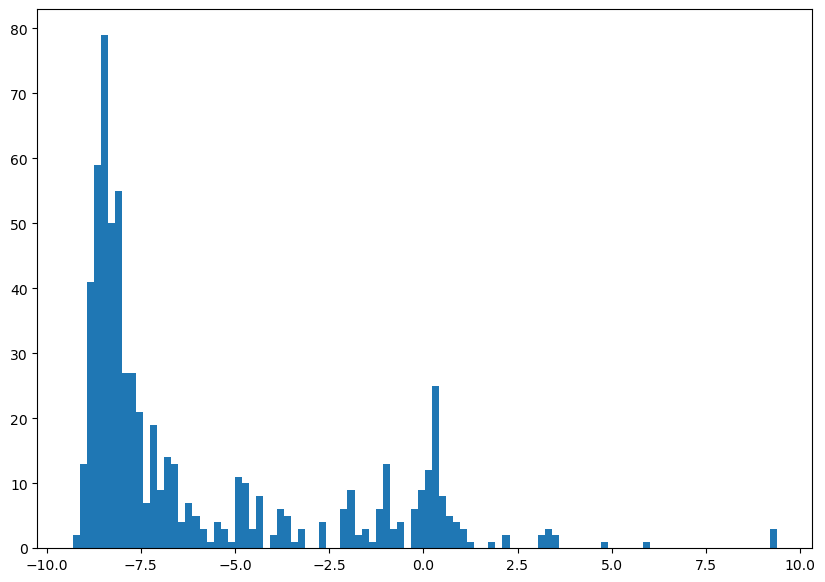

In [56]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

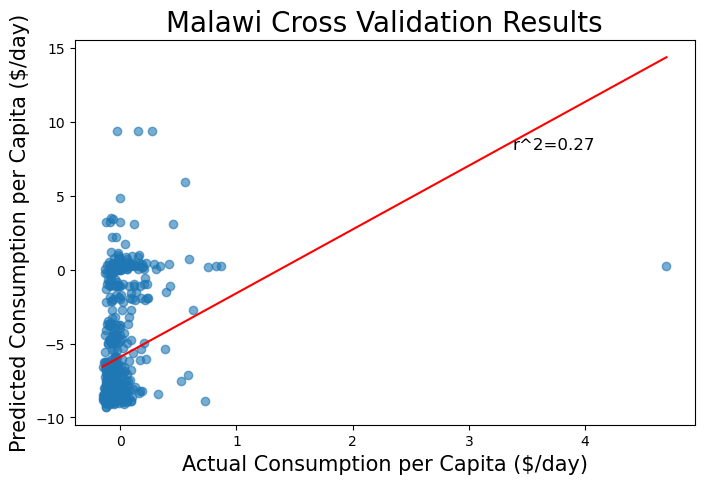

In [57]:
# Plot predictions
country = 'Malawi'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()